In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [2]:
import json
import numpy as np
import pandas as pd
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
download('punkt')
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import graphviz

[nltk_data] Downloading package punkt to /Users/mjn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def nlp_preprocess(doc_string):
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer() 
    
    tokens = word_tokenize(doc_string)
    remove_punct = [word.lower() for word in tokens if word.isalnum()]
    remove_stops = [word for word in remove_punct if word not in stopwords_english]
    stemmed = [stemmer.stem(word) for word in remove_stops]

    return stemmed


def vocabulary_dict(tokens_list):
    idx = 0
    vocab = {}
    for word in tokens_list:
        if word not in vocab.keys():
            vocab.update({word: idx})
            idx += 1
            
    return vocab


def tokens_to_vector(tokens, vocabulary):
    vector = np.zeros((1,len(vocabulary.keys())))
    for word in tokens:
        if word in vocabulary.keys():
            vector[0, int(vocabulary[word])] = 1
    
    return vector


def df_to_raw_string(research_df):
    raw_str = ""
    for row in research_df.iterrows():
        row_tup = (row[1]['CBInsightsDescription'], row[1]['QuidDescription'], row[1]['CrunchbaseDescription'])
        raw_str += " ".join(row_tup)
        
    return raw_str


def df_to_array(research_df, vocabulary):
    m = research_df.shape[0]
    n = len(vocabulary.keys())
    data_array = np.zeros((m, n))
    idx = 0
    for row in research_df.iterrows():
        raw_str = ""
        row_tup = (row[1]['CBInsightsDescription'], row[1]['QuidDescription'], row[1]['CrunchbaseDescription'])
        raw_str += " ".join(row_tup)
        tokens = nlp_preprocess(raw_str)
        vect = tokens_to_vector(tokens, vocabulary)
        data_array[idx] = vect
        idx += 1

    return data_array


def token_from_index(vocab_dict, index_value):
    key_list = list(vocab_dict.keys())
    val_list = list(vocab_dict.values())
    
    return key_list[index_value]


def plot_loss(results_dict, output_path='log-loss.jpg', show_plot=False):    
    epochs = len(results_dict['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    fig = plt.figure(figsize=(7,5))
    plt.plot(x_axis, results_dict['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results_dict['validation_1']['logloss'], label='Test')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Epochs')
    plt.title('Log-Loss')
    plt.savefig(output_path)
    if show_plot==True:
        plt.show()
    
def plot_error(results_dict, output_path='classification-error.jpg', show_plot=False):        
    # plot classification error
    epochs = len(results_dict['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot error
    fig = plt.figure(figsize=(7,5))
    plt.plot(x_axis, results_dict['validation_0']['error'], label='Train')
    plt.plot(x_axis, results_dict['validation_1']['error'], label='Test')
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.title('Classification Error')
    plt.savefig(output_path)
    if show_plot==True:
        plt.show()

def plot_feature_importance(fitted_model, output_path='feature-importance.jpg', 
                            top_n_features=10,  show_plot=False):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10))
    xgb.plot_importance(fitted_model, max_num_features=top_n_features, 
                        importance_type="weight", ax=ax[0], title="Importance: Weight")
    xgb.plot_importance(fitted_model, max_num_features=top_n_features,
                        importance_type="gain", ax=ax[1], title="Importance: Gain")
    xgb.plot_importance(fitted_model, max_num_features=top_n_features,
                        importance_type="cover", ax=ax[2],  title="Importance: Cover")
    plt.savefig(output_path)
    if show_plot==True:
        plt.show()

    

In [4]:
health_df = pd.read_csv('../data/healthcare-human-systems.csv')
health_df['class'] = 0
media_df = pd.read_csv('../data/marketing-media.csv')
media_df['class'] = 0
education_df = pd.read_csv('../data/education-training-professional-development.csv')
education_df['class'] = 0

aiml_df = pd.read_csv('../data/artificial-intelligence-machine-learning.csv')
aiml_df['class'] = 1
modeling_df = pd.read_csv('../data/modeling-simulation.csv')
modeling_df['class'] = 1
robotics_df = pd.read_csv('../data/robotics-mechatronics.csv')
robotics_df['class'] = 1

#all
corpus_df = pd.concat([health_df, media_df, education_df, aiml_df, modeling_df, robotics_df], 
                      axis=0, ignore_index=True)
#health, robotics
#corpus_df = pd.concat([health_df, robotics_df], 
#                      axis=0, ignore_index=True)

#ai, modeling
#corpus_df = pd.concat([aiml_df, modeling_df], 
#                      axis=0, ignore_index=True)

print("Train/ Test examples: " + str(corpus_df.shape[0]))

Train/ Test examples: 355


In [5]:
raw_str = df_to_raw_string(corpus_df)
tokens = nlp_preprocess(raw_str)
vocab = vocabulary_dict(tokens)
print("Total tokens: " + str(len(tokens)))
print("Unique tokens: " + str(len(vocab.keys())))

Total tokens: 34158
Unique tokens: 4094


In [6]:
X = df_to_array(corpus_df, vocab)
Y = corpus_df['class'].values

In [20]:
# split data into train and test sets
test_size = 0.10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
print("Training examples: " + str(len(y_train)))
print("Testing examples: " + str(len(y_test)))

Training examples: 319
Testing examples: 36


In [21]:
# fit model to training data
eval_metrics = ['error', 'logloss']
eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.1, max_depth=100, n_estimators=1000)
#model.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_set, verbose=False)
model.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_set, early_stopping_rounds=100, verbose=False)
results = model.evals_result()

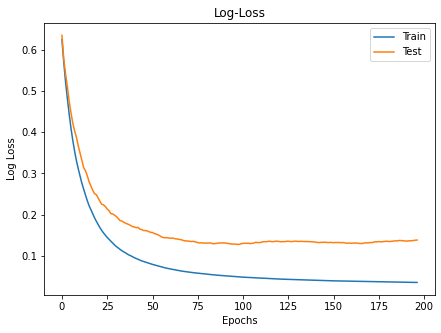

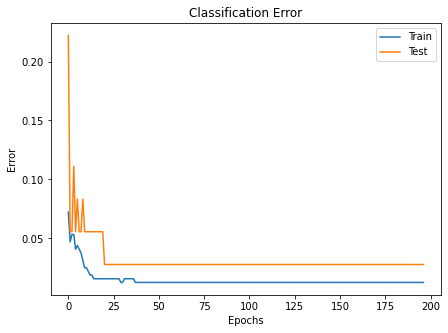

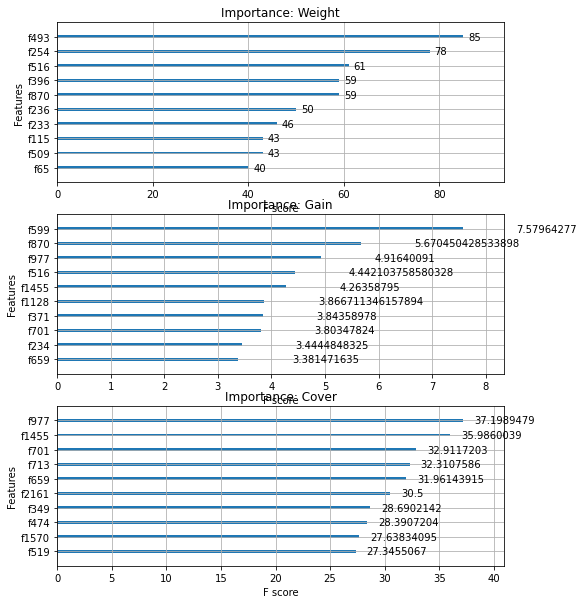

In [22]:
plot_loss(results, output_path="log-loss-init.jpg", show_plot=False)
plot_error(results, output_path="error-init.jpg", show_plot=False)
plot_feature_importance(model, output_path="important-features-init.jpg", show_plot=False)

In [23]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [24]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.22%


In [40]:
token_from_index(vocab, 701)

'depart'

In [ ]:
xgb.to_graphviz(model, num_trees=0, rankdir='LR')

In [ ]:
pred_str = "Second Front Systems is a public benefit, venture-backed software company that \
equips defense and national security professionals for long-term, continuous competition \
for access to emerging technologies. To accelerate the delivery of emerging technologies \
to U.S. and Allied warfighters.  To enable enduring strategic advantage for the U.S. and \
its allies through agile, responsive acquisition warfare. While serving in the U.S. Marine \
Corps, our co-founders Peter Dixon and Mark Butler saw firsthand the damages done by an \
outdated acquisition system to those on the frontlines of defending our country. To address \
this critical issue, they formed Second Front Systems as a public benefit corporation with \
the mission of accelerating the transition of technology to U.S. and Allied warfighters. \
Our team is comprised of trailblazers dedicated to bridging the gap between the government and private sector."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
print('Class: ' + str(pred))

In [ ]:
pred_str = "Primer enables organizations to quickly explore and utilize the world’s exponentially \
growing sources of text-based information. Our best-in-class natural language processing (NLP) \
engines and applications help you make sense of it all in real-time with human-level precision. \
Request a demo to learn more about: Primer Engines — assemble data processing pipelines with flexible \
building blocks pretrained on domain-specific data. Primer Automate — build your own NLP models, or \
retrain Primer Engines on your own data, with no technical skills required. Primer Analyze — create a \
scalable, self-curating knowledge base that can sift through billions of documents in seconds. \
Primer Extract — explore large caches of data quickly with translation, OCR, and image recognition capabilities. \
UNLOCK MACHINE INTELLIGENCE. Primer provides industrial-grade NLP applications for government agencies, \
financial institutions, Fortune 50 companies, and many other organizations. Organizations collect massive \
amounts of data — far more than human analysts can handle. As a result, much of it remains unexplored or \
underutilized. At Primer, we are dedicated to helping organizations make the best use of their investment in \
data. We do this by using best-in-class machine learning and natural language processing technologies to help \
our customers scale and optimize their intelligence workflows."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
print('Class: ' + str(pred))

In [ ]:
pred_str ="Who Is Teton Telecom? What We Offer  Mergers and Acquisitions Fractional Executive Service Mergers and Acquisitions Fiber Optics Fractional Executive Service Mergers and Acquisitions Fractional Executive Service Fractional Executive Service Fractional Executive Service Comprehensive Business Services Comprehensive Business Services Comprehensive Business Services Stakeholder Communications and Investor Relations Comprehensive Business Services Comprehensive Business Services Underwriting Adding Value Comprehensive Business Services Adding Value Social Contact Us Contact Us Help us help you! Let us know the details on your project, or whatever it is you're hoping to accomplish. We'll let you know if it's something we can help with. We look forward to hearing from you! Teton Telecom Get in Touch  apply. GoDadd"
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
print('Class: ' + str(pred))